### Invader Defender Game:

- Time is broken up into discrete epochs.
- The world is a square area that is broken up into a 6-by-6 grid of cells.
- There are two players or agents; both of them can move up, down, left, or right. At each time step, both players take their action simultaneously. Each cannot see the others' action at that time step, but the state of the system and previous actions are fully observable to each. If the chosen action takes an agent outside of the grid, then the agent remains in the current position.
- The invader, marked I, starts in the upper-left corner of the world. The defender, marked D, starts in the bottom-left corner of the world.
- The 9 cells centered around the defender's current position (see Figure 1), is the region where the invader will be captured. The game ends whenever the invader is captured by the defender, or the invader enters the fixed territory cell marked T, whichever comes first.The discount factor for future rewards is $\gamma= 0.95$.
- The goal of the defender is to capture the invader as far away as possible from the territory T. The goal of the invader is to move as close as possible to the territory T before being captured.

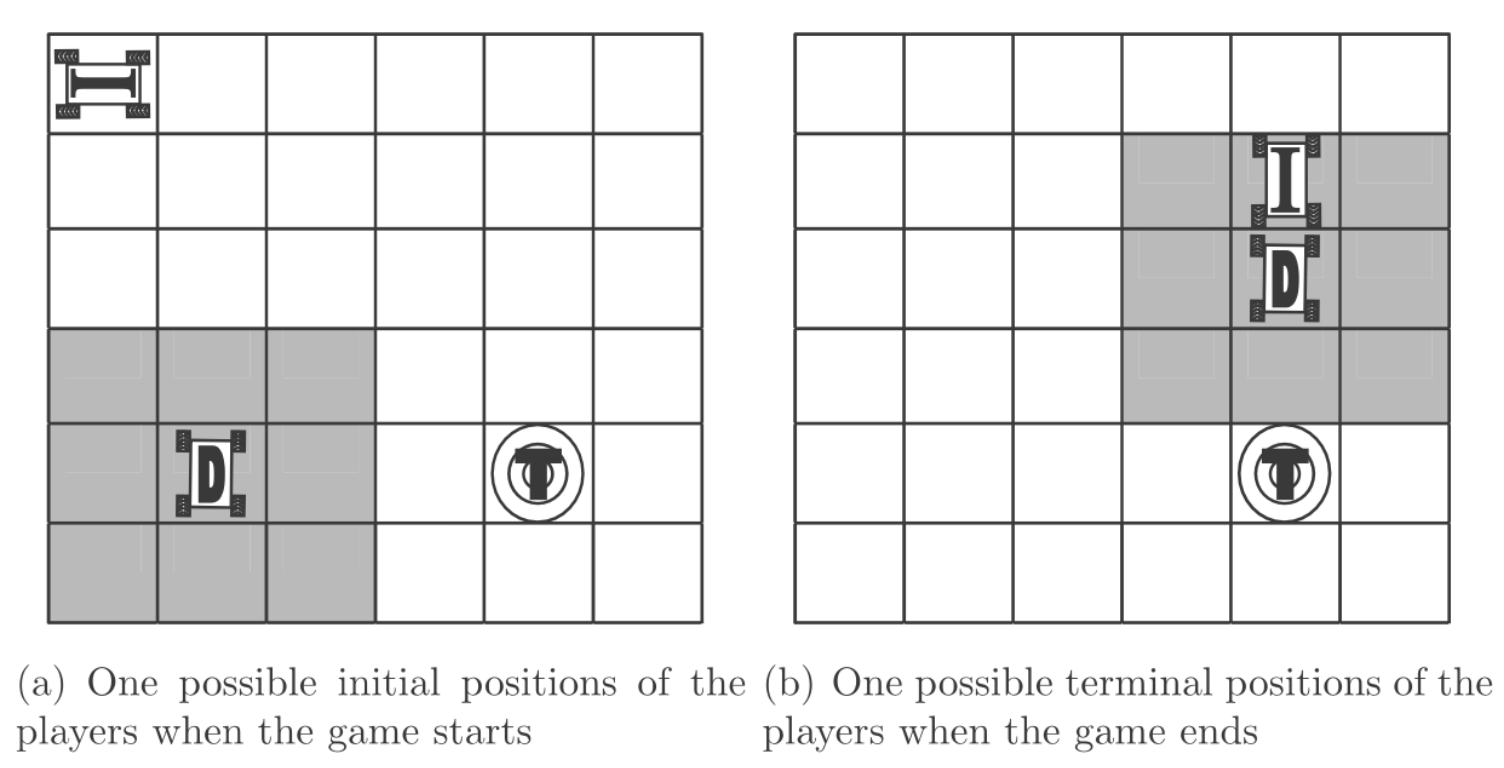


1.1 Explain how you would model this problem as a stochastic game: [10 Marks]

   (a) What is the state space, and what are the action spaces for each agent?
    
   (b) Describe the transition probability matrix for this stochastic game.
    
   (c) Which states, if any, are terminal states?
    
   (d) Derive one suitable reward function that allows the defender to achieve the goal for this task. Derive one suitable reward function that allows the invader to achieve the goal for this task. Are these the only possible suitable reward functions? Why or why not? What is the relationship between the defender's and invader's reward functions? Choosing a good reward function is critical to get good results in RL, so please choose carefully.
    
   (e) What kind of stochastic game is this (e.g. what special properties does it possess based on what you have learned about stochastic games)?


**Answer:**

**1.1 - (a)** In this problem state space represents position of the invader and defender with a tuple $s = (s_1, s_2)$ respectively where $s_1, s_2 \in \{0, \cdots, 35\}$. Each number in the tuple refers to one grid cell starting from top-left cell which is 0 to bottom-right corner which is 35. Each agent has 4 actions namely: Left(0), Down(1), Right(2), UP(3). Additionally, we add a terminal state denoted with $\emptyset$ for convenience. The joint action is represented with $a = (a_1, a_2)$ where $a_1, a_2 \in \{0, \cdots, 3\}$.

**1.1 - (b)** First, we define $d(s)$ to be the gray area around the position of the defender (i.e., $s_2$). Thus, we can write:
$$P^a_{s,s'} = \begin{cases}
\frac{0.9}{16} & \text{if } s' = \emptyset \text{ and } s_1 \in d(s)  \\
\frac{0.1}{16} & \text{if } s' \neq \emptyset \text{ and } s_1 \in d(s)  \\
\frac{1}{16} & \text{o.w.}  \\
\end{cases}$$

Let $s=(s_1,s_2)$ and function $f$ be a mapping from cell indexes to $(row,column)$ coordinates. In other words, $f(s_1)=(r_{11},r_{12}), f(s_2)=(r_{21},r_{22})$ where $r_{11},r_{12},r_{21},r_{22} \in \{ 0, \cdots, 5 \}$.

$$s'_1 = (r'_{11},r'_{12}) = \begin{cases}
(r_{11}, \max(r_{12} - 1, 0)) & \text{if } a_1 = \text{LEFT}, \\
(\min(r_{11} + 1, 5), r_{12}) & \text{if } a_1 = \text{DOWN}, \\
(r_{11}, \min(r_{12} + 1, 5)) & \text{if } a_1 = \text{RIGHT}, \\
(\max(r_{11} - 1, 0), r_{12}) & \text{if } a_1 = \text{UP}, \\
\end{cases}$$

$$s'_2 = (r'_{21},r'_{22}) = \begin{cases}
(r_{21}, \max(r_{22} - 1, 0)) & \text{if } a_2 = \text{LEFT}, \\
(\min(r_{21} + 1, 5), r_{22}) & \text{if } a_2 = \text{DOWN}, \\
(r_{21}, \min(r_{22} + 1, 5)) & \text{if } a_2 = \text{RIGHT}, \\
(\max(r_{21} - 1, 0), r_{22}) & \text{if } a_2 = \text{UP}, \\
\end{cases}$$

**1.1 - (c)** Termination happens in two cases:
1. Invader enters the cell containing letter T. (i.e. $s'=(.,28)$)
2. Invader is captured within $d(s)$ (i.e. $s'=∅$ and $s_1 \in d(s)$)

**1.1 - (d)** Since this is a zero-sum game winning of one agent means the other agent has lost. Thus, sum of rewards of agents after each transition should be zero. We will introduce two versions for the reward. The first version is sufficient for distributed q and shapley VI. These two are not the only possible functions since one can change the weight of each reward. (e.g. giving a reward of 200 instead of 100)

- Reward V1: In case of occuring a terminal condition, we compute the distance of invader to T, $d_{IT}$, and compute the reward of invader as $10(1-(d_{IT}/8))$ where 8 is the maximum possible distance to T according to the grid we have. For all the other non-terminal cases, we give invader a reward of 1 if it gets farther from the defender and -1 if gets closer to the defender. Otherwise, the reward will be zero. The defender's reward is negative of invader's reward since this is a zero-sum game.

- Reward V2: The only difference is we use a weigh of 100 instead of 10 for the terminal case and we make non-terminal cases denser by giving 1 when invader gets closer to T and gets farther from defender, 0.5 if it only gets farther from defender, -1 if it gets closer to defender and farther from T, -0.5 if it only gets closer to defender and zero otherwise.

**1.1 - (e)** This is a zero-sum stochastic game which means when one agent wins the other one loses.

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from copy import deepcopy
from matplotlib.tri import Triangulation

def to_row_col(s, ncol=36):
    return (s // ncol, s % ncol)

def to_s(row, col, ncol=36):
    return row * ncol + col

def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

def plot_triheatmap(values, M=4, N=4):
    # M, N = 4, 4  # e.g. 5 columns, 4 rows
    # values = create_demo_data(M, N)
    triangul = triangulation_for_triheatmap(M, N)
    cmaps = ['Blues', 'Greens', 'Purples', 'Reds']  # ['winter', 'spring', 'summer', 'autumn']
    norms = [plt.Normalize(-0.5, 1) for _ in range(4)]
    fig, ax = plt.subplots()

    imgs = [ax.tripcolor(t, val.ravel(), cmap='RdYlGn', vmin=0, vmax=1, ec='white')
            for t, val in zip(triangul, values)]
    for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
        val = val.reshape(N, M)
        for i in range(M):
            for j in range(N):
                v = val[j, i]
                ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], f'{v:.2f}', color='k' if 0.2 < v < 0.8 else 'w',
                        ha='center', va='center')
    cbar = fig.colorbar(imgs[0], ax=ax)

    ax.set_xticks(range(M))
    ax.set_yticks(range(N))
    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_aspect('equal', 'box')  # square cells
    plt.tight_layout()
    plt.show()

class InvaderDefenderEnv:

    def __init__(self):

        self.LEFT = 0
        self.DOWN = 1
        self.RIGHT = 2
        self.UP = 3
        self.TERMINATE = 4
        self.TERMINAL = 'terminal'
        self.MAP = ["I#####",
                    "######",
                    "######",
                    "######",
                    "#D##T#",
                    "######"]
        self.T = 28
        self.s = (0,25) # invader, defender
        self.GAMMA = 0.95
        self.nA = 4
        self.nrow = len(self.MAP)
        self.ncol = len(self.MAP[0])

    def to_row_col(self, s): # input is between 0 and 35
        return (s // self.ncol, s % self.ncol)

    def to_s(self, row, col):
        return row * self.ncol + col

    def get_defense_area(self):
        s_defender = self.s[1]
        row, col = self.to_row_col(s_defender)
        defensive_area = []
        defensive_area.append(s_defender)
        defensive_area.append(self.to_s(row + 1, col))
        defensive_area.append(self.to_s(row - 1, col))
        defensive_area.append(self.to_s(row, col + 1))
        defensive_area.append(self.to_s(row, col - 1))
        defensive_area.append(self.to_s(row + 1, col + 1))
        defensive_area.append(self.to_s(row - 1, col - 1))
        defensive_area.append(self.to_s(row + 1, col - 1))
        defensive_area.append(self.to_s(row - 1, col + 1))
        return defensive_area

    def get_sp(self, row, col, a):
        if a == self.LEFT:
            col = max(col - 1, 0)
        elif a == self.DOWN:
            row = min(row + 1, self.nrow - 1)
        elif a == self.RIGHT:
            col = min(col + 1, self.ncol - 1)
        elif a == self.UP:
            row = max(row - 1, 0)
        return (row, col)

    def pr(self, s, a):
        s_invader, s_defender = s
        a_invader, a_defender = a

        i_row, i_col = self.to_row_col(s_invader)
        d_row, d_col = self.to_row_col(s_defender)
        i_sp = self.to_s(*self.get_sp(i_row, i_col, a_invader))
        d_sp = self.to_s(*self.get_sp(d_row, d_col, a_defender))

        if s_invader == self.T:
            return {self.TERMINAL: 1.0}
        elif s_invader in self.get_defense_area():
            sp = {self.TERMINAL: 0.9, (i_sp, d_sp): 0.1}
        else:
            sp = {(i_sp, d_sp): 1.0}
        return sp

    def distance_from(self, s1, s2):
        row1, col1 = self.to_row_col(s1)
        row2, col2 = self.to_row_col(s2)
        return abs(row1 - row2) + abs(col1 - col2)

    def reward(self, s, sp): # zero-sum game
        s_invader, s_defender = s
        max_distance_to_T = 8
        if sp == self.TERMINAL:
            d_IT = self.distance_from(s_invader, self.T)
            r = 1-(d_IT/max_distance_to_T)
            r *= 10
            return r, -r # invader, defender
        else:
            sp_invader, sp_defender = sp
            prev_d_ID = self.distance_from(s_defender, s_invader)
            d_ID = self.distance_from(sp_defender, sp_invader)
            if d_ID > prev_d_ID:
                return 1, -1
            elif d_ID < prev_d_ID:
                return -1, 1
            return 0, 0

    def reward2(self, s, sp): # zero-sum game
        s_invader, s_defender = s
        max_distance_to_T = 8
        if sp == self.TERMINAL:
            d_IT = self.distance_from(s_invader, self.T)
            r = 1-(d_IT/max_distance_to_T)
            r *= 100
            return r, -r # invader, defender
        else:
            sp_invader, sp_defender = sp
            prev_d_ID = self.distance_from(s_defender, s_invader)
            d_ID = self.distance_from(sp_defender, sp_invader)
            prev_d_IT = self.distance_from(s_invader, self.T)
            d_IT = self.distance_from(sp_invader, self.T)
            prev_d_DT = self.distance_from(s_defender, self.T)
            d_DT = self.distance_from(sp_defender, self.T)
            if d_ID > prev_d_ID and d_IT < prev_d_IT:
                return 1, -1
            elif d_ID < prev_d_ID and d_DT > prev_d_DT:
                return -1, 1
            elif d_ID > prev_d_ID:
                return 0.5, -0.5
            elif d_ID < prev_d_ID:
                return -0.5, 0.5

            return 0, 0

    def reset(self):
        self.s = (0,25)
        return self.s

    def step(self, a, reward_type=1):
        sp = self.pr(self.s, a)

        sp_keys = list(sp.keys())
        sp_realization = np.random.choice(np.arange(len(sp_keys)), p=list(sp.values()))
        sp_realization = sp_keys[sp_realization]

        if reward_type == 1:
            r = self.reward(self.s, sp_realization)
        else:
            r = self.reward2(self.s, sp_realization)
        self.s = sp_realization
        return sp_realization, r, sp_realization == self.TERMINAL, {'prob': sp[sp_realization]*1/16}

    def VI_step(self, s, a, agent=0):
        sp = self.pr(s, a)
        for sp_realization, prob in sp.items():
            r = self.reward(s, sp_realization)
            yield sp_realization, prob*1/16, r[0], sp_realization == self.TERMINAL # r[agent]


    def render(self):
        if self.s == self.TERMINAL:
            return
        for i in range(self.nrow):
            for j in range(self.ncol):
                if (i,j) == self.to_row_col(self.s[0]):
                    print('I', end='')
                elif (i,j) == self.to_row_col(self.s[1]):
                    print('D', end='')
                elif (i,j) == self.to_row_col(self.T):
                    print('T', end='')
                else:
                    print('#', end='')
            print()
        print()

### Minimax Q-learning


In [ ]:
def plotQ_invader_minimax(env, Q_invader, s2=25):

    Nlst, Elst, Slst, Wlst = [], [], [], []
    for s1 in range(0,36):
        s = to_s(s1,s2)

        Wlst.append(np.min(Q_invader[s,env.LEFT,:]))
        Nlst.append(np.min(Q_invader[s,env.UP,:]))
        Slst.append(np.min(Q_invader[s,env.DOWN,:]))
        Elst.append(np.min(Q_invader[s,env.RIGHT,:]))

    data = [np.array(Nlst), np.array(Elst), np.array(Slst), np.array(Wlst)]
    plot_triheatmap(data,6,6)

def plotQ_defender_minimax(env, Q_defender, s1=0):

    Nlst, Elst, Slst, Wlst = [], [], [], []
    for s2 in range(0,36):
        s = to_s(s1,s2)

        Wlst.append(np.max(Q_defender[s,:,env.LEFT]))
        Nlst.append(np.max(Q_defender[s,:,env.UP]))
        Slst.append(np.max(Q_defender[s,:,env.DOWN]))
        Elst.append(np.max(Q_defender[s,:,env.RIGHT]))

    data = [np.array(Nlst), np.array(Elst), np.array(Slst), np.array(Wlst)]
    plot_triheatmap(data,6,6)


def test_minimax_q_learning(max_learner, min_learner, render=True):
    env = InvaderDefenderEnv()
    env.reset()
    done = False
    if render:
      env.render()
    i = 0
    episode_reward = 0
    max_steps = 200
    while not done:
        s = to_s(*env.s)
        a1 = max_learner.act(env, training=False)
        a2 = min_learner.act(env, training=False)
        _, r, done, _ = env.step((a1, a2))
        episode_reward += r[0]
        if render:
          env.render()
        i += 1
        if i == max_steps:
            break
    return episode_reward


class MinimaxQLearner:
    def __init__(self, env, mode='max'):

        self.agents = {'max': 0, 'min': 1}
        self.mode = mode
        self.num_states = (env.nrow * env.ncol) ** 2 + 1
        self.Q = np.zeros((self.num_states, env.nA, env.nA))
        self.alpha = np.ones(self.num_states) * 0.3
        self.epsilon = np.ones(self.num_states) * 0.6
        self.eps_decay = 0.9999
        self.alpha_decay = 0.99
        self.missed_updates = 0
        self.pi = np.ones((self.num_states, env.nA)) / env.nA

    def build_G(self, env, s):
        G = np.zeros((env.nA, env.nA))
        for a in range(env.nA):
            for b in range(env.nA):
                G[a, b] = self.Q[s, a, b]
        return G

    def equilibrium(self, env, G, s=None):
        Aub = np.ones((env.nA, 5))
        if self.mode == 'max':
            Aub[:, :-1] = -G.T
        else:
            Aub *= -1
            Aub[:, :-1] = G
        b_ub = np.zeros(env.nA)
        Aeq = np.ones((1, env.nA + 1))
        Aeq[0, -1] = 0
        beq = np.array([1])
        c = np.zeros(env.nA + 1)
        if self.mode == 'max':
            c[-1] = -1
        else:
            c[-1] = 1
        bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (None, None))
        res = linprog(c, A_ub=Aub, b_ub=b_ub, A_eq=Aeq, b_eq=beq, bounds=bounds, method='highs-ds')
        if res.success:
            if s is not None:
                self.pi[s] = res.x[:-1]
            return res.x[:-1], res.x[-1]  # strategies, value
        else:
            return [0.25, 0.25, 0.25, 0.25], None

    def act(self, env, training = True):
        s = to_s(*env.s)
        if training:
            if np.random.rand() < self.epsilon[s]: # explore
                a = np.random.choice(env.nA)
            else: # exploit
                best_response = {}
                for a in range(env.nA):
                    if self.mode == 'max':
                        best_response[a] = self.Q[s, a, :].min()
                    else:
                        best_response[a] = self.Q[s, :, a].max()
                a = np.argmax(list(best_response.values())) if self.mode == 'max' else np.argmin(list(best_response.values()))
            self.epsilon[s] = max(0.01, self.epsilon[s] * self.eps_decay)
        else:
            best_response = {}
            for a in range(env.nA):
                if self.mode == 'max':
                    best_response[a] = self.Q[s, a, :].min()
                else:
                    best_response[a] = self.Q[s, :, a].max()
            a = np.argmax(list(best_response.values())) if self.mode == 'max' else np.argmin(
                list(best_response.values()))
        return a

    def update(self, env, a1, a2, s, sp, r):
        G_sp = self.build_G(env, sp)
        _, V_sp = self.equilibrium(env, G_sp, sp)
        prev_Q = deepcopy(self.Q)
        if V_sp is not None:
            self.Q[s, a1, a2] += self.alpha[s] * (r[0] + env.GAMMA * V_sp - self.Q[s, a1, a2])
            self.alpha[s] = max(0.01, self.alpha[s] * self.alpha_decay) # decay alpha
        else:
            self.missed_updates += 1
        max_diff = np.max(np.abs(prev_Q - self.Q))
        return max_diff

In [ ]:
env = InvaderDefenderEnv()
max_learner = MinimaxQLearner(env, mode='max')
min_learner = MinimaxQLearner(env, mode='min')
max_steps = 200
diff1, diff2 = [], []
test_rewards = []
for i in tqdm(range(100000)):
    done = False
    env.reset()
    step = 0
    while not done and step < max_steps:
        a1 = max_learner.act(env)
        a2 = min_learner.act(env)

        s = to_s(*env.s)
        sp, r, done, _ = env.step((a1, a2), reward_type=2)
        if done:
            sp = max_learner.num_states - 1
        else:
            sp = to_s(*sp)

        max_diff1 = max_learner.update(env, a1, a2, s, sp, r)
        max_diff2 = min_learner.update(env, a1, a2, s, sp, r)
        diff1.append(max_diff1)
        diff2.append(max_diff2)
        step += 1

    if i % 100 == 0:
      test_rewards.append(test_minimax_q_learning(max_learner, min_learner, render=False))


100%|██████████| 100000/100000 [56:27<00:00, 29.52it/s]


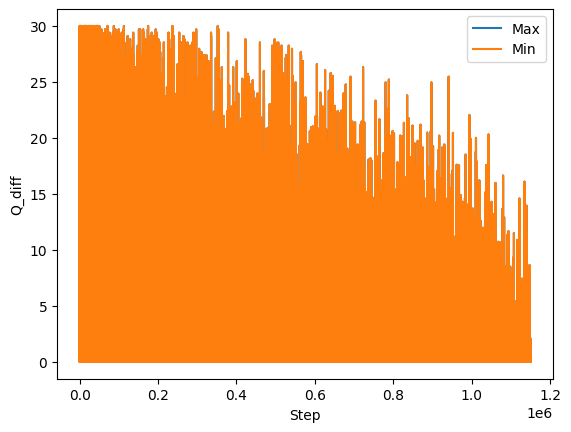

In [ ]:
plt.plot(diff1, label='Max')
plt.plot(diff2, label='Min')
plt.xlabel('Step')
plt.ylabel('Q_diff')
plt.legend()
plt.show()

Since the training takes a long time in this algorithm we only test every 100 episodes.

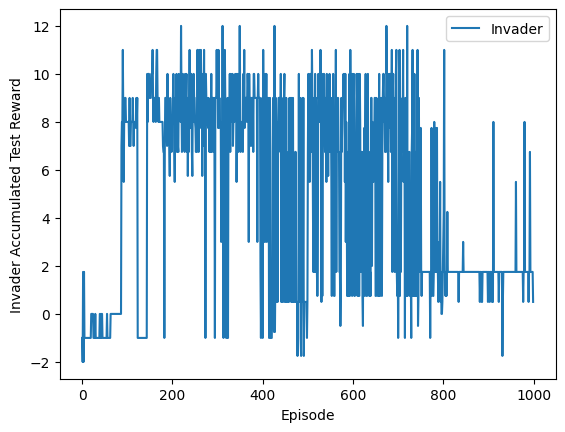

In [ ]:
plt.plot(test_rewards, label='Invader')
plt.xlabel('Episode')
plt.ylabel('Invader Accumulated Test Reward')
plt.legend()
plt.show()

In [ ]:
test_minimax_q_learning(max_learner, min_learner, render=True)

I#####
######
######
######
#D##T#
######

#I####
######
######
#D####
####T#
######

##I###
######
#D####
######
####T#
######

######
#DI###
######
######
####T#
######



1.75

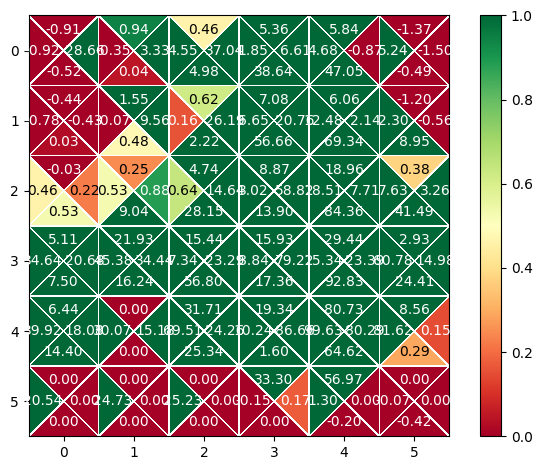

In [ ]:
plotQ_invader_minimax(env, max_learner.Q, s2=25)

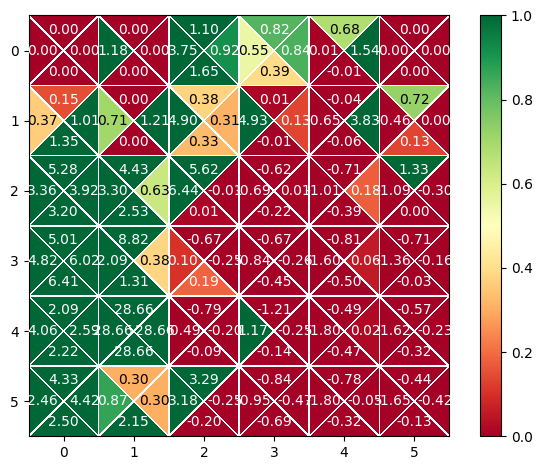

In [ ]:
plotQ_defender_minimax(env, min_learner.Q, s1=0)